In [ ]:
import numpy as np
import pandas as pd
import os
import datetime
import random as random
import pathlib
import glob
from functools import reduce
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
import math
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')


In [ ]:
##Custom Polar K-means: Distance Metric polar
class K_Means:
    def __init__(self, k, tol=0.01, max_iter=8000):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}

        for i in range(self.max_iter):
            self.classifications = {}

            for i in range(self.k):
                x=random.randrange(0, len(data))
                self.centroids[i] = data[x]

            for i in range(self.k):
                self.classifications[i] = []
            

            for featureset in data:
                distances = [math.sqrt(((featureset[0]-self.centroids[centroid][0])/self.centroids[centroid][0])**2+(featureset[1]-self.centroids[centroid][1])**2) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
            
            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)
            
            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False
            if optimized:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    print(self.centroids)
                    break
    def predict(self,data):
           distances = [math.sqrt(((data[0][0]-self.centroids[centroid][0])/self.centroids[centroid][0])**2+(data[0][1]-self.centroids[centroid][1])**2) for centroid in self.centroids]
           classification = distances.index(min(distances))
           return classification     

    def cluster_centers(self):
            return current_centroids

In [ ]:
#Polar Projection
def polar_project(data):
    real_component,img_component,theta=[],[],[]
    for i,value in enumerate(data):
           angle=(math.pi/2)*((i-1)/(len(data)-1))
           real_component.append(value*math.cos(angle))
           img_component.append(value*math.sin(angle))
          #  theta.append(math.degrees(math.atan(value*math.sin(angle)/value*math.cos(angle))))
    return np.array(real_component),np.array(img_component)


In [ ]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
source_path = pathlib.Path("/content/drive/MyDrive/dataset/halfhourly_dataset/")
source_string="/content/drive/MyDrive/dataset/halfhourly_dataset"
csv_file_count = len(list(source_path.glob('*.csv')))
print(csv_file_count)

60


In [ ]:
def rename_drop_columns(df):
    for count,i in enumerate(df):
        x=i.iloc[5]["ID"]
        i.columns=["ID",x]
        i.drop("ID",axis=1,inplace=True)
    return df


In [ ]:
filenames = glob.glob(source_string + "/*.csv")
data,meter_count=pd.DataFrame(),0
# for filename in filenames:
for filename in tqdm(filenames):
         df=pd.read_csv(filename,dtype="object",low_memory=True)
         df.columns=["ID","Timestamp","KWH"]
         df = df.set_index('Timestamp')
         meter_list=list(df.ID.unique())
         meter_count=meter_count+len(meter_list)
         sub_df=[df[df["ID"]==i] for i in meter_list]
         sub_df=rename_drop_columns(sub_df)
         dummy=reduce(lambda df1,df2: pd.merge(df1,df2,left_index=True,right_index=True,suffixes=(),how="outer"), sub_df)
         data =pd.merge(data,dummy,left_index=True,right_index=True,how="outer")
dty=data.copy()
       

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
data.reset_index(inplace=True)                          #Taking timestamp out first for further processing
data.Timestamp=pd.to_datetime(data.Timestamp,unit="ns")
data1=data.copy()
print("Initial dataset:\n",data1.shape)


Initial dataset:
 (40388, 3001)


In [ ]:
data=data1.copy()
data=data.dropna(axis=0,how="all")
data=data.dropna(axis=1,how="all")
data=data.dropna(axis=0,thresh=2500)
data=data.dropna(axis=1,thresh=10000)
data.set_index("Timestamp",inplace=True) 
print("After some processing:\nShape of the dataset",data.shape)

After some processing:
Shape of the dataset (28832, 2960)


In [ ]:
data_newang=data.groupby(data.index.date).count()       ##How many kwh values in a day, for all dates
data_newang[(data_newang.sum(axis=1)%48)<1].index       ##Day having least missing value "%48<1", and 48 values for maximum users

Index([2012-07-20, 2012-07-22, 2012-07-25, 2012-07-29, 2012-08-06, 2012-10-21,
       2012-10-26, 2012-12-06, 2012-12-11, 2012-12-31, 2013-03-29, 2013-04-23,
       2013-06-16, 2013-07-19, 2013-10-06, 2013-10-26, 2013-12-04, 2013-12-10,
       2013-12-12, 2014-01-06, 2014-01-10, 2014-02-14],
      dtype='object')

In [ ]:
mask = (data.index > "2014-02-14") & (data.index <= "2014-02-15") ##Cut the dataframe of specific date by using a mask
try_df=data.loc[mask]
print("One day profile with",try_df.shape[1],"users")
print("Missing values in newly created one day dataframe : ",try_df.isna().sum().sum())
try_df=try_df.dropna(axis=1,thresh=48)                            #dropping users with all missing values that day
print("Final number of users: ",try_df.shape[1],"\nMissing values ",try_df.isna().sum().sum())
print("Retaining One day profile with",try_df.shape[1],"users")             

One day profile with 2959 users
Missing values in newly created one day dataframe :  13593
Final number of users:  2669 
Missing values  0
Retaining One day profile with 2669 users


In [ ]:
dataset=try_df.T.copy()

dataset=dataset.astype(float)
#Feature Extraction
total_consumption=dataset.sum(axis=1).values
peak_consumption=dataset.max(axis=1).values
##Adding extracted features in a dataframe
dataset_features=pd.DataFrame()
dataset_features["User"]=dataset.index.values
dataset_features["total_consumption"]=total_consumption
dataset_features["peak_consumption"]=peak_consumption

dataset_features.head()

,User,total_consumption,peak_consumption
0,MAC000002,13.506,1.016
1,MAC000246,13.172,1.328
2,MAC003223,19.802,1.886
3,MAC003239,8.602,1.004
4,MAC003252,12.938,1.340


Value count in peak consumption : 
 (4.61, 6.147]          10
(3.073, 4.61]          57
(1.537, 3.073]        420
(-0.00615, 1.537]    2182
Name: peak_consumption, dtype: int64

Value count in total consumption : 
 (108.867, 145.156]       2
(72.578, 108.867]       16
(36.289, 72.578]       135
(-0.145, 36.289]      2516
Name: total_consumption, dtype: int64


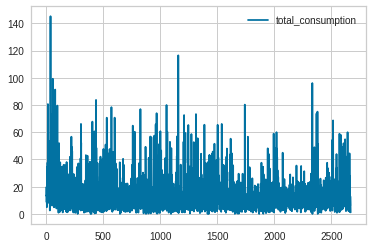

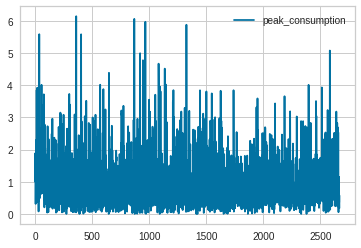

In [ ]:
##Visualise All Data Together
dataset_features.loc[:,["total_consumption"]].plot()
dataset_features.loc[:,["peak_consumption"]].plot()
print("Value count in peak consumption : \n",pd.cut(dataset_features.peak_consumption,4).value_counts().sort_values(ascending=True))
print("\nValue count in total consumption : \n",pd.cut(dataset_features.total_consumption,4).value_counts().sort_values(ascending=True))

#Visualise One day profile in raw and polar form

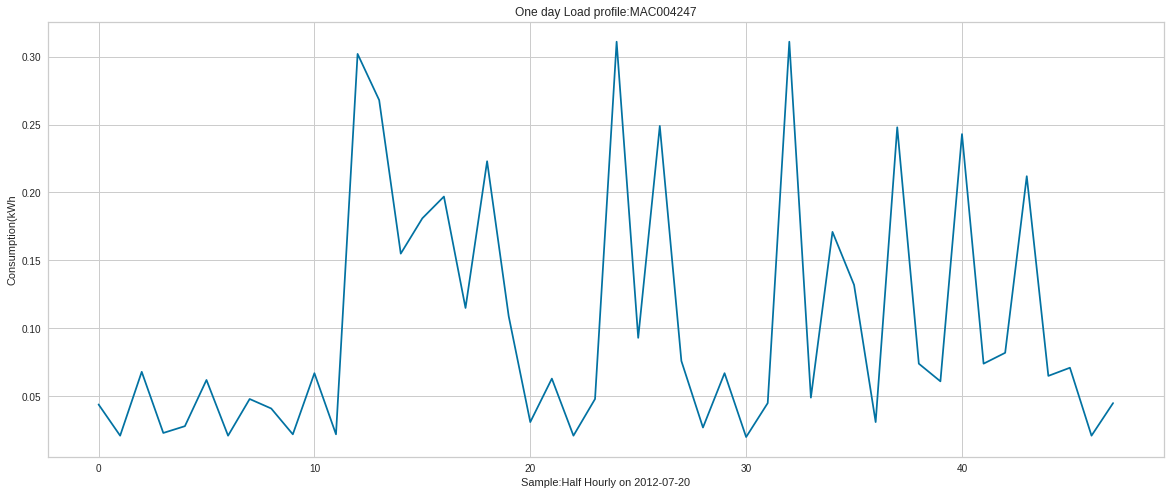

In [ ]:
#Plotting random customer profile for one day
name=range(48) #len(dataset.columns))
plt.figure(figsize=(20,8))
plt.xlabel("Sample:Half Hourly on 2012-07-20")
plt.ylabel("Consumption(kWh")
plt.title("One day Load profile:MAC004247")
plt.plot(name,dataset.iloc[5,:].values,linestyle = 'solid')

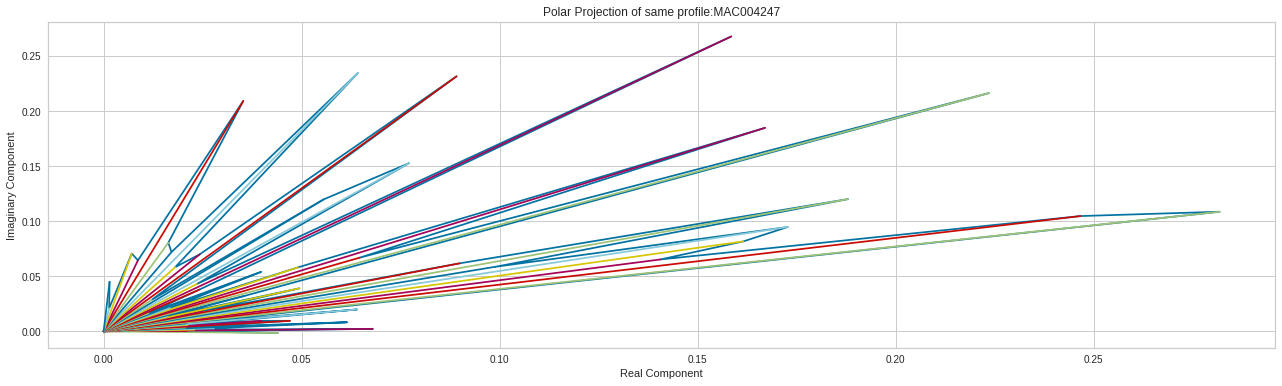

In [ ]:
###Polar projection of above Figure
x1,y1=polar_project(dataset.iloc[5,:].values)
plt.figure(figsize=(22,6))
plt.xlabel("Real Component")
plt.ylabel("Imaginary Component")
plt.title("Polar Projection of same profile:MAC004247")
plt.plot(x1,y1,"+",linestyle = 'solid')
plt.plot([np.zeros(len(x1)), np.array(x1)], [np.zeros(len(y1)), np.array(y1)],"+",linestyle = 'solid')
plt.show()

#Preparing dataset for clustering:Polar projection

In [ ]:
from sklearn.model_selection import train_test_split
train_dataset,test_dataset=train_test_split(dataset,test_size=0.30, random_state=42)

In [ ]:
print(train_dataset.shape)
print(test_dataset.shape)

(1868, 48)
(801, 48)


In [ ]:
###This has set us with data we will have after every fixed interval
##Accounting time complexity from now on

In [ ]:
import time
t1 = time.perf_counter()
real,img,theta,magni=[],[],[],[]
for i in range(len(train_dataset)):
  x,y=polar_project(train_dataset.iloc[i,:].values)
  x=x.sum()
  y=y.sum()
  real.append(x)
  img.append(y)
  magni.append(math.sqrt(x**2+y**2))
  theta.append(math.degrees(math.atan(y/x)))
t2 = time.perf_counter()
print('time taken to run:',t2-t1)

time taken to run: 0.3190477610005473


In [ ]:
dataset_train_polar=pd.DataFrame(magni,columns=["magni"],index=train_dataset.index.values)
dataset_train_polar["theta"]=theta
dataset_train_polar["real"]=real
dataset_train_polar["img"]=img
dataset_train_polar=dataset_train_polar.fillna(dataset_train_polar.mean())

In [ ]:
dataset_train_polar.head()

,magni,theta,real,img
MAC004006,11.926930,53.301942,7.127509,9.562964
MAC001689,19.183782,52.110354,11.781578,15.139747
MAC000642,12.691263,49.267975,8.281329,9.617055
MAC003968,10.949306,45.847409,7.626976,7.855987
MAC004174,3.846919,58.179883,2.028304,3.268756


In [ ]:
# t1 = time.perf_counter()
# from sklearn.preprocessing import StandardScaler
# scaler1 = StandardScaler()
# dummy=scaler1.fit_transform(dataset_train_polar)
# train_polar=pd.DataFrame(dummy,columns=["magni","theta","real","img"])
# t2 = time.perf_counter()
# print('time taken to run:',t2-t1)
# train_polar.index=dataset_train_polar.index.values
# train_polar

# # from sklearn.preprocessing import MinMaxScaler
# # scaler1 = MinMaxScaler()
# # dummy=scaler1.fit_transform(dataset_train_polar)
# # train_polar=pd.DataFrame(dummy,columns=["real","theta","img"])
# # t2 = time.perf_counter()
# # print('time taken to run:',t2-t1)

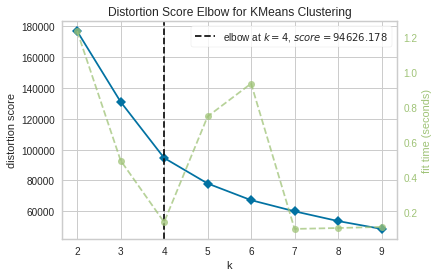

In [ ]:
# Import ElbowVisualizer for optimum clusters
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(train_polar.loc[:,["magni","theta"]])        # Fit data to visualizer
visualizer.show()  

#Applying Kmeans on real part only (total consumption)
##using sklearn Kmeans and euclidean distance metric

In [ ]:
train_polar=dataset_train_polar.copy()
km = KMeans(n_clusters=4)  
km.fit(train_polar.loc[:,["magni"]])   
clusters = km.labels_.tolist()
train_polar["only_real_euclidean"]=clusters

In [ ]:
train_polar.tail()

,magni,theta,real,img,only_real_euclidean
MAC001107,32.805404,53.145007,19.676415,26.249442,1
MAC004986,3.291102,43.625840,2.382299,2.270683,0
MAC002534,8.733600,54.070141,5.124828,7.071910,0
MAC000918,1.603302,37.685568,1.268817,0.980143,0
MAC003054,1.193244,42.466137,0.880228,0.805624,0


#Kmeans on polar data using polar distance metric

In [ ]:
####Our defined Kmeans and distance metric
polar_kmeans = K_Means(k=4)
x=polar_kmeans.fit(train_polar.loc[:,["magni","theta"]].values)
X=train_polar.loc[:,["magni","theta"]].values
labels_new=[]
for i in range(len(train_polar)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = polar_kmeans.predict(predict_me)
    labels_new.append(prediction)

train_polar["polar_label"]=labels_new



In [ ]:
train_polar.polar_label.unique()

array([1, 2, 3, 0])

In [ ]:
import time
t1 = time.perf_counter()
real,img,thetatest,magnitest=[],[],[],[]
for i in range(len(test_dataset)):
  x,y=polar_project(test_dataset.iloc[i,:].values)
  x=x.sum()
  y=y.sum()
  real.append(x)
  img.append(y)
  thetatest.append(math.degrees(math.atan(y/x)))
  magnitest.append(math.sqrt(x**2+y**2))
t2 = time.perf_counter()
print('time taken to run polar conversion:',t2-t1)
dataset_test_polar=pd.DataFrame(magnitest,columns=["magni"],index=test_dataset.index.values)
dataset_test_polar["theta"]=thetatest
dataset_test_polar["real"]=real
dataset_test_polar["img"]=img
dataset_test_polar=dataset_test_polar.fillna(dataset_test_polar.mean())
test_polar=dataset_test_polar.copy()
# t1 = time.perf_counter()
# dummy=scaler1.fit_transform(dataset_test_polar)
# test_polar=pd.DataFrame(dummy,columns=["magni","theta"])
# t2 = time.perf_counter()
# print('time taken to run standard scaling:',t2-t1)
# test_polar.index=dataset_test_polar.index.values


time taken to run polar conversion: 0.13366361200041865


In [ ]:
test_polar.head()

,magni,theta,real,img
MAC005299,21.706424,46.650292,14.900364,15.784423
MAC005537,8.596723,53.622545,5.098735,6.921456
MAC004290,12.015849,38.776938,9.367437,7.525407
MAC002311,6.307401,40.140246,4.821811,4.066134
MAC000264,6.728407,43.773413,4.858457,4.654767


# Prediction on test data

In [ ]:
prediction_real=km.predict(test_polar.loc[:,["magni"]].values)

X=test_polar.loc[:,["magni","theta"]].values
labels_test=[]
for i in range(len(test_polar)):
    predict_me = np.array(X[i].astype(float))
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = polar_kmeans.predict(predict_me)
    labels_test.append(prediction)


In [ ]:
test_polar["only_real_euclidean"]=prediction_real
test_polar["polar_label"]=labels_test
test_polar.head()

,magni,theta,real,img,only_real_euclidean,polar_label
MAC005299,21.706424,46.650292,14.900364,15.784423,0,0
MAC005537,8.596723,53.622545,5.098735,6.921456,2,3
MAC004290,12.015849,38.776938,9.367437,7.525407,0,2
MAC002311,6.307401,40.140246,4.821811,4.066134,2,2
MAC000264,6.728407,43.773413,4.858457,4.654767,2,0


#Visualising Clustering

In [ ]:
dataset_features=dataset_features.set_index("User")
train_polar=pd.merge(dataset_features,train_polar,left_index=True,right_index=True,how="right")
test_polar=pd.merge(dataset_features,test_polar,left_index=True,right_index=True,how="right")

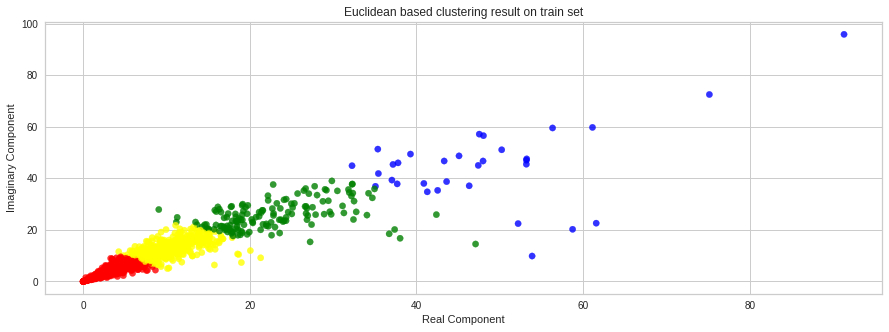

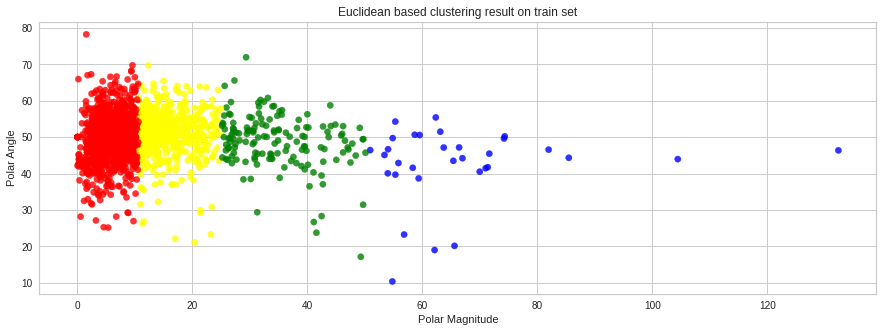

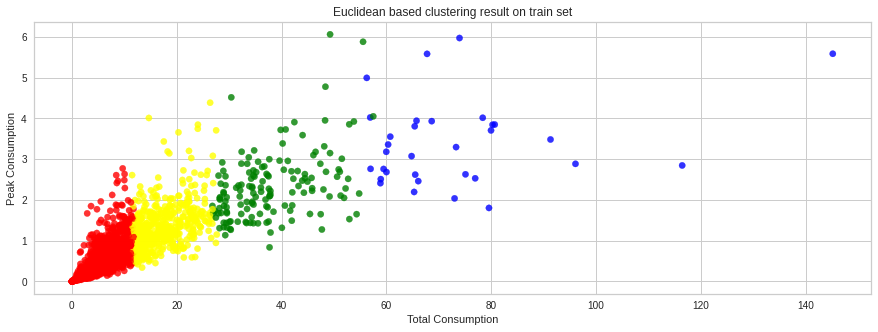

In [ ]:
%matplotlib inline
# define and map colors
colors = ['red','yellow','blue','Green',]
train_polar['c'] = train_polar["only_real_euclidean"].map({0:colors[0], 1:colors[3], 2:colors[1], 3:colors[2]})#,4:colors[4]
fig, ax = plt.subplots(1, figsize=(15,5))
# plot data
plt.title("Euclidean based clustering result on train set")
plt.xlabel("Real Component")
plt.ylabel("Imaginary Component")
plt.scatter(train_polar["real"], train_polar["img"], c=train_polar.c, alpha = 0.8, s=40,)
fig, ax = plt.subplots(1, figsize=(15,5))
plt.title("Euclidean based clustering result on train set")
plt.xlabel("Polar Magnitude")
plt.ylabel("Polar Angle")
plt.scatter(train_polar["magni"], train_polar["theta"], c=train_polar.c, alpha = 0.8, s=40,)
fig, ax = plt.subplots(1, figsize=(15,5))
plt.title("Euclidean based clustering result on train set")
plt.xlabel("Total Consumption")
plt.ylabel("Peak Consumption")
plt.scatter(train_polar["total_consumption"], train_polar["peak_consumption"], c=train_polar.c, alpha = 0.8, s=40,)
train_polar=train_polar.drop(["c","cen_x"],axis=1)

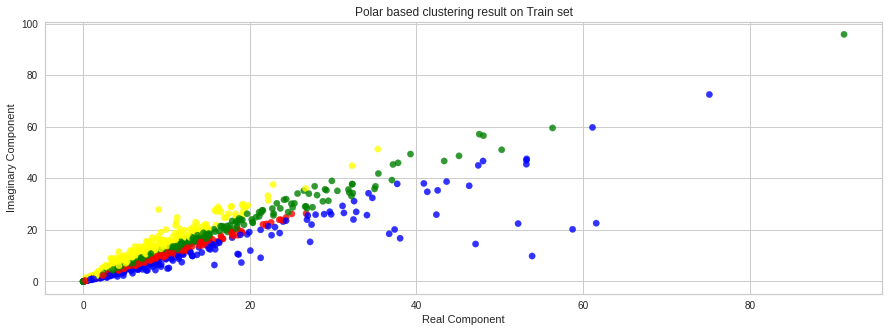

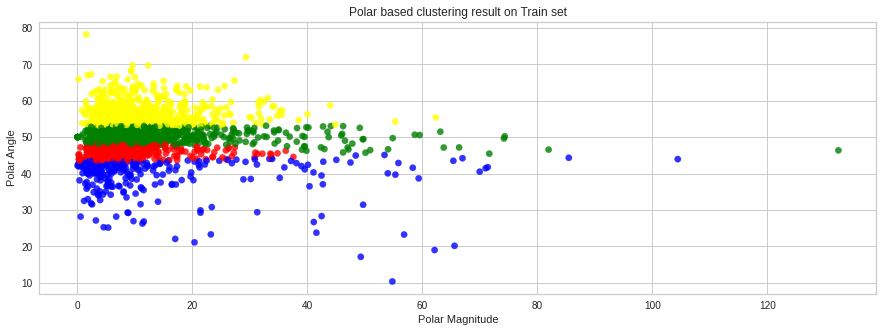

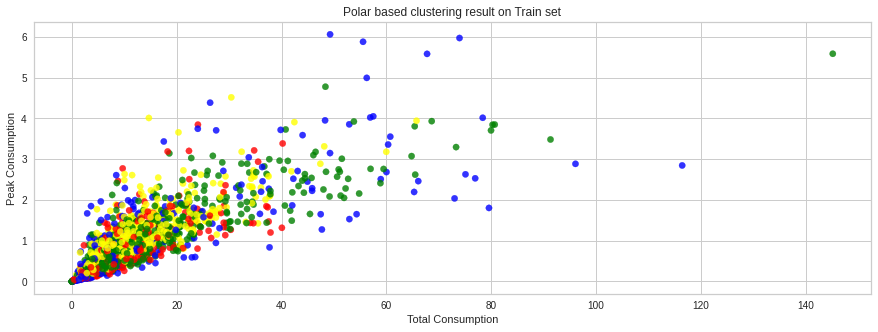

In [ ]:
%matplotlib inline

# define and map colors
colors = ['red','yellow', 'Green','blue']
train_polar['c'] = train_polar["polar_label"].map({0:colors[3], 1:colors[1], 2:colors[2], 3:colors[0]})#4:colors[4]

fig, ax = plt.subplots(1, figsize=(15,5))
# plot data
plt.title("Polar based clustering result on Train set")
plt.xlabel("Real Component")
plt.ylabel("Imaginary Component")
plt.scatter(train_polar["real"], train_polar["img"], c=train_polar.c, alpha = 0.8, s=40,)
fig, ax = plt.subplots(1, figsize=(15,5))
plt.title("Polar based clustering result on Train set")
plt.xlabel("Polar Magnitude")
plt.ylabel("Polar Angle")
plt.scatter(train_polar["magni"], train_polar["theta"], c=train_polar.c, alpha = 0.8, s=40,)
fig, ax = plt.subplots(1, figsize=(15,5))
plt.title("Polar based clustering result on Train set")
plt.xlabel("Total Consumption")
plt.ylabel("Peak Consumption")
plt.scatter(train_polar["total_consumption"], train_polar["peak_consumption"], c=train_polar.c, alpha = 0.8, s=40,)

# Plotting resuly of test dataset

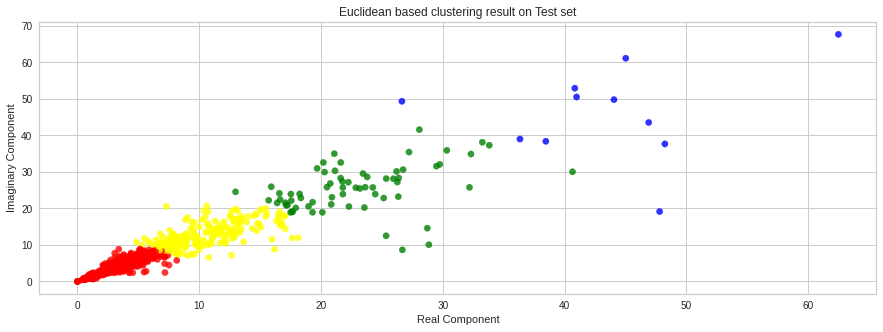

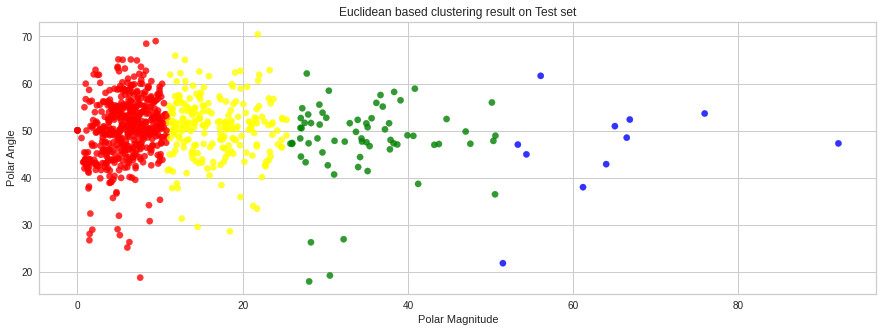

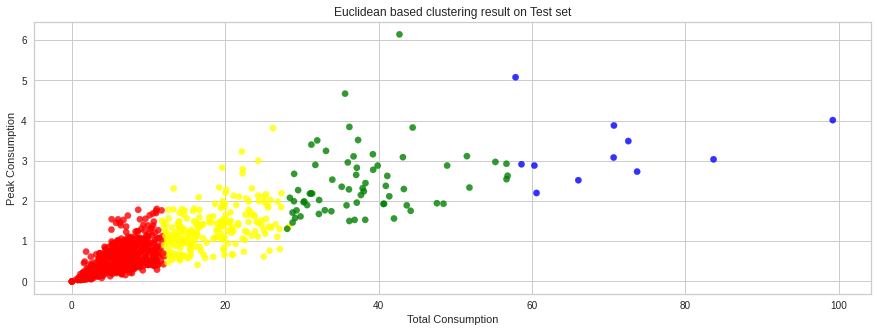

In [ ]:
%matplotlib inline
# define and map colors
colors = ['Green','blue','red','yellow',]
test_polar['c'] = test_polar["only_real_euclidean"].map({0:colors[3], 1:colors[1], 2:colors[2], 3:colors[0]})

fig, ax = plt.subplots(1, figsize=(15,5))
# plot data
plt.title("Euclidean based clustering result on Test set")
plt.xlabel("Real Component")
plt.ylabel("Imaginary Component")
plt.scatter(test_polar["real"], test_polar["img"], c=test_polar.c, alpha = 0.8, s=40,)
fig, ax = plt.subplots(1, figsize=(15,5))
plt.title("Euclidean based clustering result on Test set")
plt.xlabel("Polar Magnitude")
plt.ylabel("Polar Angle")
plt.scatter(test_polar["magni"], test_polar["theta"], c=test_polar.c, alpha = 0.8, s=40,)
fig, ax = plt.subplots(1, figsize=(15,5))
plt.title("Euclidean based clustering result on Test set")
plt.xlabel("Total Consumption")
plt.ylabel("Peak Consumption")
plt.scatter(test_polar["total_consumption"], test_polar["peak_consumption"], c=test_polar.c, alpha = 0.8, s=40,)


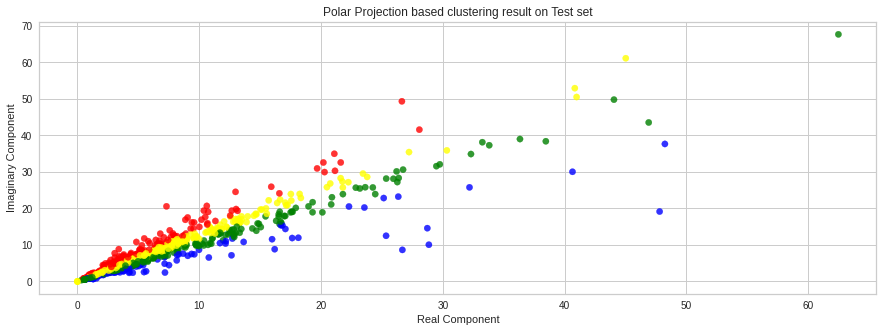

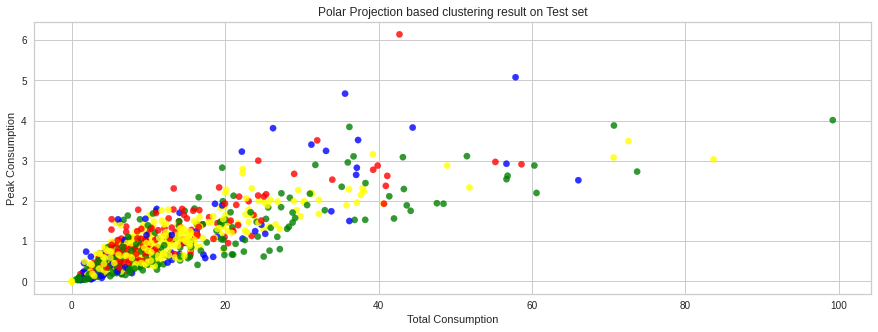

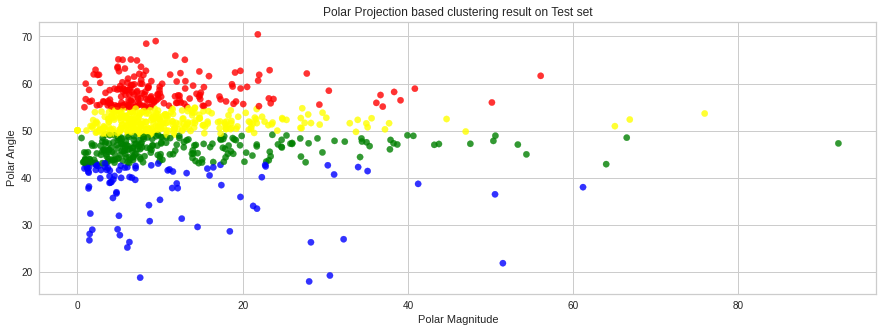

In [ ]:
%matplotlib inline
# define and map colors
colors = ['blue','yellow', 'Green','red']
test_polar['c'] = test_polar["polar_label"].map({0:colors[2], 1:colors[3], 2:colors[0], 3:colors[1]})

fig, ax = plt.subplots(1, figsize=(15,5))
# plot data
plt.title("Polar Projection based clustering result on Test set")
plt.xlabel("Real Component")
plt.ylabel("Imaginary Component")
plt.scatter(test_polar["real"], test_polar["img"], c=test_polar.c, alpha = 0.8, s=40)
fig, ax = plt.subplots(1, figsize=(15,5))
# plot data
plt.title("Polar Projection based clustering result on Test set")
plt.xlabel("Total Consumption")
plt.ylabel("Peak Consumption")
plt.scatter(test_polar["total_consumption"], test_polar["peak_consumption"], c=test_polar.c, alpha = 0.8, s=40)
fig, ax = plt.subplots(1, figsize=(15,5))
# plot data
plt.title("Polar Projection based clustering result on Test set")
plt.xlabel("Polar Magnitude")
plt.ylabel("Polar Angle")
plt.scatter(test_polar["magni"], test_polar["theta"], c=test_polar.c, alpha = 0.8, s=40)


#Load Profiling
##Visualising average load profile after clustering

In [ ]:
cluster0traine=train_polar[train_polar.only_real_euclidean==0].index.values
cluster1traine=train_polar[train_polar.only_real_euclidean==1].index.values
cluster2traine=train_polar[train_polar.only_real_euclidean==2].index.values
cluster3traine=train_polar[train_polar.only_real_euclidean==3].index.values
cluster0teste=test_polar[test_polar.only_real_euclidean==0].index.values
cluster1teste=test_polar[test_polar.only_real_euclidean==1].index.values
cluster2teste=test_polar[test_polar.only_real_euclidean==2].index.values
cluster3teste=test_polar[test_polar.only_real_euclidean==3].index.values
cluster0e=[*cluster0traine,*cluster0teste]
cluster1e=[*cluster1traine,*cluster1teste]
cluster2e=[*cluster2traine,*cluster2teste]
cluster3e=[*cluster3traine,*cluster3teste]
cluster0_userse=dataset[dataset.index.isin(cluster0e)]
plot_0e=cluster0_userse.mean(axis=0).values
cluster1_userse=dataset[dataset.index.isin(cluster1e)]
plot_1e=cluster1_userse.mean(axis=0).values
cluster2_userse=dataset[dataset.index.isin(cluster2e)]
plot_2e=cluster2_userse.mean(axis=0).values
cluster3_userse=dataset[dataset.index.isin(cluster3e)]
plot_3e=cluster3_userse.mean(axis=0).values

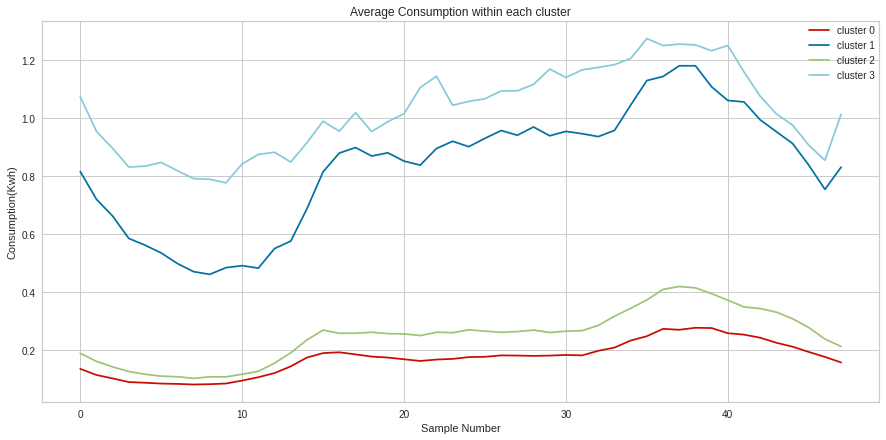

In [ ]:
# Plot average profile load of individual clusters 

choose_interval=[0,48]
fig, ax = plt.subplots(1, figsize=(15,7))
plt.plot(range(len(dataset.iloc[1,choose_interval[0]:choose_interval[1]].values)),plot_0e[choose_interval[0]:choose_interval[1]],color='r', label='cluster 0')
plt.plot(range(len(dataset.iloc[1,choose_interval[0]:choose_interval[1]].values)),plot_1e[choose_interval[0]:choose_interval[1]],color='b', label='cluster 1')
plt.plot(range(len(dataset.iloc[1,choose_interval[0]:choose_interval[1]].values)),plot_2e[choose_interval[0]:choose_interval[1]],color='g', label='cluster 2')
plt.plot(range(len(dataset.iloc[1,choose_interval[0]:choose_interval[1]].values)),plot_3e[choose_interval[0]:choose_interval[1]],color='c', label='cluster 3')
plt.xlabel("Sample Number")
plt.ylabel("Consumption(Kwh)")
plt.title("Average Consumption within each cluster")

plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
plt.show()

In [ ]:
cluster0train=train_polar[train_polar.polar_label==0].index.values
cluster1train=train_polar[train_polar.polar_label==1].index.values
cluster2train=train_polar[train_polar.polar_label==2].index.values
cluster3train=train_polar[train_polar.polar_label==3].index.values
cluster0test=test_polar[test_polar.polar_label==0].index.values
cluster1test=test_polar[test_polar.polar_label==1].index.values
cluster2test=test_polar[test_polar.polar_label==2].index.values
cluster3test=test_polar[test_polar.polar_label==3].index.values
cluster0=[*cluster0train,*cluster0test]
cluster1=[*cluster1train,*cluster1test]
cluster2=[*cluster2train,*cluster2test]
cluster3=[*cluster3train,*cluster3test]
cluster0_users=dataset[dataset.index.isin(cluster0)]
plot_0=cluster0_users.mean(axis=0).values
cluster1_users=dataset[dataset.index.isin(cluster1)]
plot_1=cluster1_users.mean(axis=0).values
cluster2_users=dataset[dataset.index.isin(cluster2)]
plot_2=cluster2_users.mean(axis=0).values
cluster3_users=dataset[dataset.index.isin(cluster3)]
plot_3=cluster3_users.mean(axis=0).values

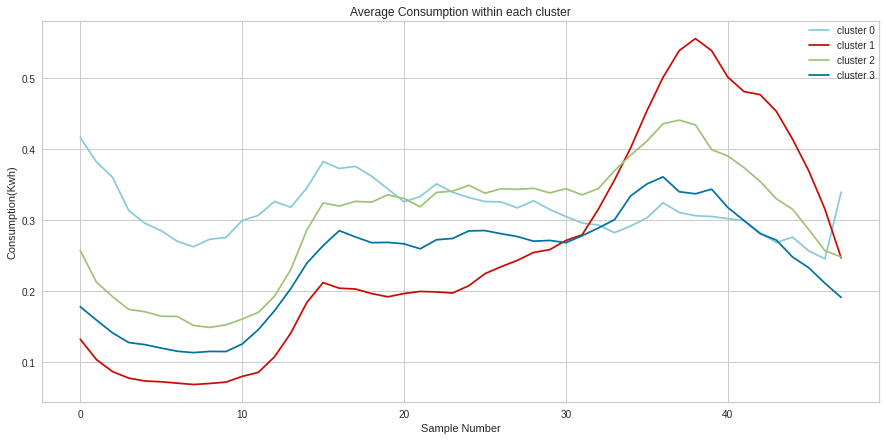

In [ ]:
# Plot average profile load of individual clusters 

choose_interval=[0,48]
fig, ax = plt.subplots(1, figsize=(15,7))
plt.plot(range(len(dataset.iloc[1,choose_interval[0]:choose_interval[1]].values)),plot_0[choose_interval[0]:choose_interval[1]],color='c', label='cluster 0')
plt.plot(range(len(dataset.iloc[1,choose_interval[0]:choose_interval[1]].values)),plot_1[choose_interval[0]:choose_interval[1]],color='r', label='cluster 1')
plt.plot(range(len(dataset.iloc[1,choose_interval[0]:choose_interval[1]].values)),plot_2[choose_interval[0]:choose_interval[1]],color='g', label='cluster 2')
plt.plot(range(len(dataset.iloc[1,choose_interval[0]:choose_interval[1]].values)),plot_3[choose_interval[0]:choose_interval[1]],color='b', label='cluster 3')
plt.xlabel("Sample Number")
plt.ylabel("Consumption(Kwh)")
plt.title("Average Consumption within each cluster")

plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0)
plt.show()

# [+] We have plotted the mean load of clusters above
##[+] The mean values of clusters should increase when there is high peak/total consumption of users within that cluster.
### To test this we can compare the actual total/peak consumption of users(after grouping them in clusters) to compare,which clustering reflect it better.

#Check if **Polar clusters** tell about peak and total consumption
##As desired:

In [ ]:
compare_dfmean=pd.DataFrame()
compare_dfmean["cluster0_mean"]=cluster0_users.mean().values
compare_dfmean["cluster1_mean"]=cluster1_users.mean().values
compare_dfmean["cluster2_mean"]=cluster2_users.mean().values
compare_dfmean["cluster3_mean"]=cluster3_users.mean().values
# compare_df.iloc[35:]
compare_df=pd.DataFrame()
compare_df["cluster0_mean"]=cluster0_users.max().values
compare_df["cluster1_mean"]=cluster1_users.max().values
compare_df["cluster2_mean"]=cluster2_users.max().values
compare_df["cluster3_mean"]=cluster3_users.max().values
# compare_df.iloc[35:]
compare_dfT=pd.DataFrame()
compare_dfT["cluster0_mean"]=cluster0_users.iloc[:,].sum().values
compare_dfT["cluster1_mean"]=cluster1_users.sum().values
compare_dfT["cluster2_mean"]=cluster2_users.sum().values
compare_dfT["cluster3_mean"]=cluster3_users.sum().values
# compare_dfT.iloc[35:]

Polar clusters :Using Mean consumption within cluster


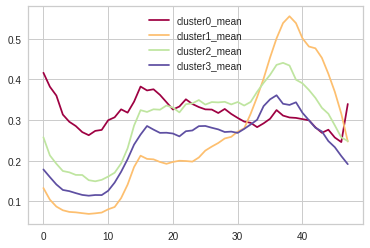

In [ ]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)
compare_dfmean.plot(colormap=cmap)
print("Polar clusters :Using Mean consumption within cluster")

Polar clusters :Using peak consumption within clusters


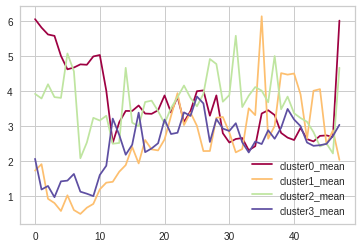

In [ ]:
compare_df.plot(colormap=cmap)
print("Polar clusters :Using peak consumption within clusters")

Polar clusters :Using total consumption within cluster


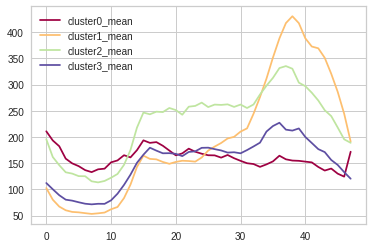

In [ ]:
compare_dfT.plot(colormap=cmap)
print("Polar clusters :Using total consumption within cluster")

#Checking same on **Euclidean** based clusters
## General methodology

In [ ]:
comparee_dfmean=pd.DataFrame()
comparee_dfmean["cluster0_mean"]=cluster0_userse.mean().values
comparee_dfmean["cluster1_mean"]=cluster1_userse.mean().values
comparee_dfmean["cluster2_mean"]=cluster2_userse.mean().values
comparee_dfmean["cluster3_mean"]=cluster3_userse.mean().values
# compare_df.iloc[35:]
comparee_df=pd.DataFrame()
comparee_df["cluster0_mean"]=cluster0_userse.max().values
comparee_df["cluster1_mean"]=cluster1_userse.max().values
comparee_df["cluster2_mean"]=cluster2_userse.max().values
comparee_df["cluster3_mean"]=cluster3_userse.max().values
# compare_df.iloc[35:]
comparee_dfT=pd.DataFrame()
comparee_dfT["cluster0_mean"]=cluster0_userse.sum().values
comparee_dfT["cluster1_mean"]=cluster1_userse.sum().values
comparee_dfT["cluster2_mean"]=cluster2_userse.sum().values
comparee_dfT["cluster3_mean"]=cluster3_userse.sum().values
# compare_dfT.iloc[35:]

Polar clusters :Using mean consumption within clusters


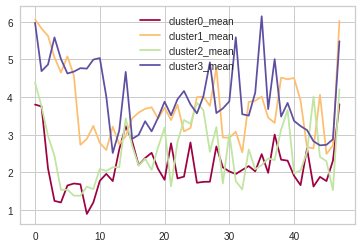

In [ ]:
comparee_df.plot(colormap=cmap)
print("Polar clusters :Using mean consumption within clusters")

Polar clusters :Using peak consumption within clusters


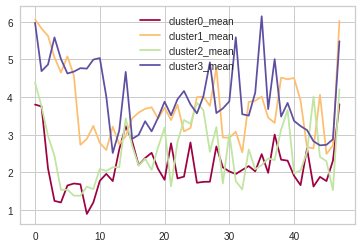

In [ ]:
comparee_df.plot(colormap=cmap)
print("Polar clusters :Using peak consumption within clusters")

Polar clusters :Using total consumption within cluster


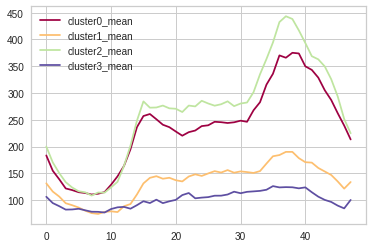

In [ ]:
comparee_dfT.plot(colormap=cmap)
print("Polar clusters :Using total consumption within cluster")